In [1]:
# Load packages ----
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from IPython.display import HTML
from IPython.display import Markdown as md
from IPython.core.display import HTML as Center
from config import marker, qof_measure_marker, start_date, end_date, demographics, codelist_path
from IPython.display import Image, display
import base64

from utilities import *
%matplotlib inline

# QOF Asthma in OpenSAFELY

# Contents

<ul id="docNav">
<li> <a href="#intro">Introduction</a>
<li> <a href="#methods">Methods</a>
    <ul>
    <li> <a href="#AST007">Asthma indicator ast007</a>
    <li> <a href="#codelists">Codelists</a>
</ul>
<li> <a href="#results">Results</a>
    <ul>
        <li> <a href="#results_total">Total</a>
        <li> <a href="#results_var_gp">Variation across GP practices</a>
        <li> <a href="#results_by_sex">Breakdown by sex</a>
        <li> <a href="#results_by_age_band">Breakdown by age band</a>
        <li> <a href="#results_by_region">Breakdown by region</a>
        <li> <a href="#results_by_imd">Breakdown by IMD quintiles</a>
        <li> <a href="#results_by_ethnicity">Breakdown by ethnicity</a>
        <li> <a href="#results_by_learning_disability">Breakdown by learning disability</a>
        <li> <a href="#results_by_care_home_status">Breakdown by NHS care home status</a>
    </ul>
<li> <a href="#discussion">Discussion</a>
<li> <a href="#references">References</a>

</ul>

<a id="intro"></a>
# Introduction

> *The Quality and Outcomes Framework (QOF) is a voluntary annual reward and incentive programme for all GP practices in England* ([NHSD, 2021a](https://qof.digital.nhs.uk/)). 
> *The objective of the Quality and Outcomes Framework (QOF) is to improve the quality of care patients are given by rewarding practices for the quality of care they provide to their patients, based on a number of indicators across a range of key areas of clinical care and public health.*
> *QOF participation by GP practices is very high, with 96.7% of practices participating in the 2020/21 publication* ([NHSD, 2021b](https://digital.nhs.uk/data-and-information/publications/statistical/quality-and-outcomes-framework-achievement-prevalence-and-exceptions-data/2020-21)).

OpenSAFELY is a secure analytics platform for electronic patient records built by our group on behalf of NHS England to deliver urgent academic and operational research during the pandemic (e.g., [Curtis et al., 2021](https://bjgp.org/content/72/714/e63); [Williamson et al., 2020](https://www.nature.com/articles/s41586-020-2521-4)). 
Analyses can currently run across all patients' full pseudonymised primary care records, with patient-level linkage to various sources of secondary care data. 
The OpenSAFELY-TPP is a Trusted Research Environment (TRE) containing the routine clinical data of 23.4m people, approximately 40% of England’s population.

Currently QOF reports are published at the end of the financial year, and consist of prevalence rates and indicator achievement rates for clinical areas by NHS geographic breakdowns from region to practice.
We set out to replicate the indicator logic for a variety of QOF clinical indicators in OpenSAFELY-TPP and describe trends monthly over time, before and during the pandemic.
We also describe how the indicators vary between key clinical, regional and demographic subgroups.

This report describes the results of implementing the QOF asthma indicator of percentage of patients with asthma, on the register, who have had an asthma review in the preceding 12 months that includes an assessment of asthma control using a validated asthma control questionnaire, a recording of the number of exacerbations, an assessment of inhaler technique and a written personalised asthma plan (ast007) in the OpenSAFELY-TPP TRE. 

<a id="methods"></a>
# Methods

Using OpenSAFELY-TPP, covering 40% of England's population, we implemented the QOF Asthma register (previously defined [here](https://github.com/opensafely/asthma_sro)) and indicator logic, covering data between March 2019 and March 2022.

The **study population** is all people registered to a GP practice and aged 6 or older at the end of each month included in the study. The QOF asthma register, represents all patients aged 6 and over with an unresolved asthma diagnosis who have received an asthma-related drug treatment in the 12 months prior to the month reported. The indicator covered in this report is defined as the percentage of patients with asthma, on the register, who have had an asthma review in the preceding 12 months that includes an assessment of asthma control using a validated asthma control questionnaire, a recording of the number of exacerbations, an assessment of inhaler technique and a written personalised asthma plan. 

More details about the QOF business rules and codelists can be found [here](https://digital.nhs.uk/data-and-information/data-collections-and-data-sets/data-collections/quality-and-outcomes-framework-qof/quality-and-outcome-framework-qof-business-rules/qof-business-rules-v46.0-2021-2022-baseline-release). Dashboards presenting the annual targets of all QOF indicators published by NHSD are available [here](https://digital.nhs.uk/data-and-information/data-tools-and-services/data-services/general-practice-data-hub/quality-outcomes-framework-qof). All analytical code used in this report is available to view in the [OpenSAFELY GitHub repository](https://github.com/opensafely/asthma_indicators_qof).

<a id="AST007"></a>
### QOF asthma indicator definition (ast007)

The percentage of patients with asthma, on the register, who have had an asthma review in the preceding 12 months that includes an assessment of asthma control using a validated asthma control questionnaire, a recording of the number of exacerbations, an assessment of inhaler technique and a written personalised asthma plan.

#### Denominator definition

| Rule number | Rule description | Action if true | Action if false |
|:---|:---|:---|:---|
| 1 | Select patients from the specified population who meet both the criteria below: <br>•	Patient has an asthma review on the same day as a written personalised asthma plan. <br>•	Patient has an assessment of asthma control using a validated asthma control questionnaire and a recording of the number of exacerbations within the one month leading up to and including date of the asthma review. <br>•	The review above was in the 12 month period up to and including the study period end date. <br>Pass all remaining patients to the next rule. | Select | Next rule |
| 2 | Pass to the next rule all patients passed to this rule who have no asthma resolved code since the latest asthma diagnosis. Reject the remaining patients. | Reject | Next rule |
| 3 | Reject patients passed to this rule who chose not to receive asthma monitoring in the 12 months leading up to and including the study period end date. Pass all remaining patients to the next rule. | Reject | Next rule |
| 4 | Reject patients passed to this rule who chose not to receive asthma quality indicator care in the 12 months leading up to and including the study period end date. Pass all remaining patients to the next rule. | Reject | Next rule |
| 5 | Reject patients passed to this rule who have not responded to at least two asthma care review invitations, made at least 7 days apart, in the 12 months leading up to and including the study period end date. Pass all remaining patients to the next rule. More details in full specification.| Reject | Next rule |
| 6 | Reject patients passed to this rule who were recently diagnosed (first asthma diagnosis recorded in the 3 month period leading up to and including the study period end date). Pass all remaining patients to the next rule.| Reject | Next rule |
| 7 | Reject patients passed to this rule who recently registered at the practice (patient registered in the 3 months leading up to and including the study period end date). Select the remaining patients. | Reject | Select |

#### Numerator definition

| Rule number | Rule description | Action if true | Action if false |
|:---|:---|:---|:---|
| 1 | Select patients from the denominator who meet both the criteria below: <br>•	Patient has an asthma review on the same day as a written personalised asthma plan. <br>•	 Patient has an assessment of asthma control using a validated asthma control questionnaire and a recording of the number of exacerbations within the one month leading up to and including date of the asthma review. <br>•	The review above was in the 12-month period up to and including the period end date. <br>Reject the remaining patients.| Select | Reject |


<a id="codelists"></a>

## Codelists

The clinical code clusters defined in the published QOF business rules, used in the definition of this indicator, are listed below. These codelists are published in the NHS Primary Care Domain Reference Set Portal, or the SNOMED CT browser in the case of the asthma-related drug treatment codes codelist. Detailed information on compilation and sources for every individual codelist is available at https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/ and all codelists are available under open licenses for review and re-use by the broader research community.


| Cluster name | Description | SNOMED CT |
|:---|:---|:---|
| [REV_COD](https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/rev_cod/20200812/) | Asthma review codes | ^999011931000230101 |
| [WRITPASTP_COD](https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/writpastp_cod/20200812/) | Written personalised asthma plan codes | ^999020651000230102 |
| [ASTCONTASS_COD](https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/astcontass_cod/20200812/) | Assessment of asthma control using a validated asthma control questionnaire codes | ^999019931000230100 |
| [ASTEXACB_COD](https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/astexacb_cod/20200812/) | Codes indicating the number of asthma exacerbations | ^999020051000230106 |
| [ASTPCAPU_COD](https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/astpcapu_cod/20200812/) | Codes for asthma quality indicator care unsuitable for patient | ^999009851000230100 |
| [ASTMONDEC_COD](https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/astmondec_cod/20200812/) | Codes indicating the patient has chosen not to receive asthma monitoring | ^999009651000230104 |
| [ASTPCADEC_COD](https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/astpcadec_cod/20200812/) | Codes indicating the patient has chosen not to receive asthma quality indicator care | ^999009811000230104 |
| [ASTINVITE_COD](https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/astinvite_cod/20200812/) | Invite for asthma care review codes | ^999012051000230101 |
| [AST_COD](https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/ast_cod/20210127/) | Asthma diagnosis codes | ^999012891000230104 |

### Codelists used for breakdowns

The following codelists are used for breakdowns of indicators.

| Codelist name | Description | Coding system |
|:---|:---|:---|
| [Ethnicity](https://www.opencodelists.org/codelist/opensafely/ethnicity/2020-04-27) | A list of ethnicity codes in use in UK general practice including aggregate grouping at two levels (6 and 16). 6 census ethnicity groupings are used in this report. | CTV3 |
| [NHS England Care Homes residential status](https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/carehome_cod/5d2f363a/) | This codelists supports analysis of records of people who may reside in a nursing or care home. | SNOMED CT |
| [Learning disabilities](https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/ld_cod/20210127/) | The following codes are used to indicate learning disability. | SNOMED CT |




<a id="results"></a>
# Results

The table below shows a comparison between the QOF published prevalence of asthma and the prevalence found implementing the QOF asthma register methodology in the OpenSAFELY-TPP TRE. 

| Financial year | Published national QOF prevalence of Asthma | Asthma prevalence in OpenSAFELY-TPP using QOF methodology |
|:---|:---|:---|
|2021/22|Not published|TBC%|
|2020/21*|TBC%|TBC%|
|2019/20|TBC%|TBC%|
|2018/19|TBC%|TBC%|

*Due to the impact of the COVID-19 pandemic on activity in general practice, QOF implementation was changed for the 2020-21 reporting year. The majority of QOF indicators were income protected (i.e. payments were made to practices irrespective of activity recorded for indicators in 2020-21), to enable practices to direct resources towards COVID-19 response and targeting care at the most vulnerable and high-need groups. These changes mean that indicator data may be inaccurate for the 2020-21 reporting year, and comparisons with data from previous years would be misleading.

National published figures of QOF condition prevalence are published by NHSD are available [here](https://digital.nhs.uk/data-and-information/data-tools-and-services/data-services/general-practice-data-hub/quality-outcomes-framework-qof).


In [14]:
codelist = pd.read_csv(f'../{codelist_path}')

image_paths = {d: f'../output/plot_{d}.png' for d in demographics}
image_paths['total'] = '../output/plot_total.png'

<a id="results_total"></a>
### Asthma indicator achievement trend over time

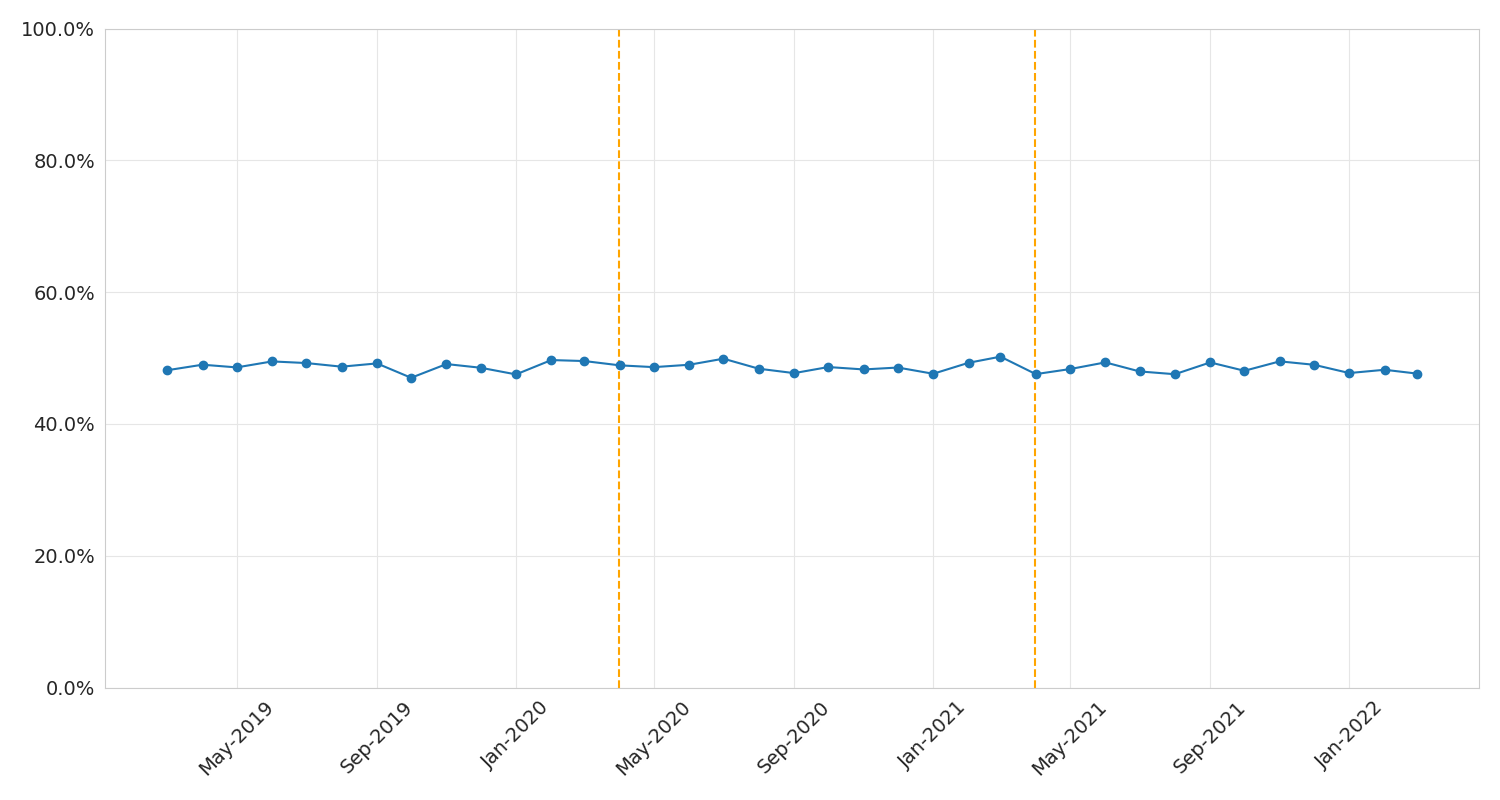

In [13]:
Image(filename=image_paths['total'])

### Decile chart of asthma indicator achievement in GP practices 

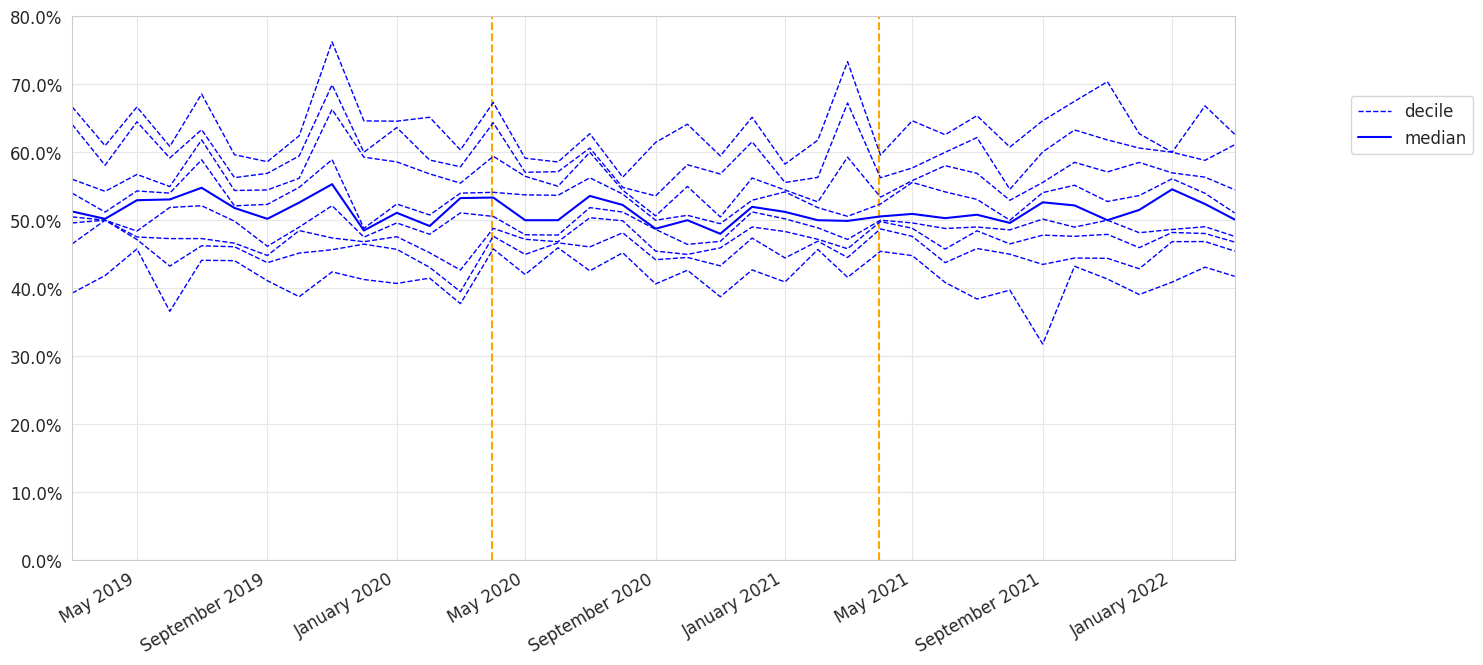

In [5]:
Image(filename='../output/decile_chart.png')

<a id="results_by_sex"></a>
### Asthma indicator achievement by sex

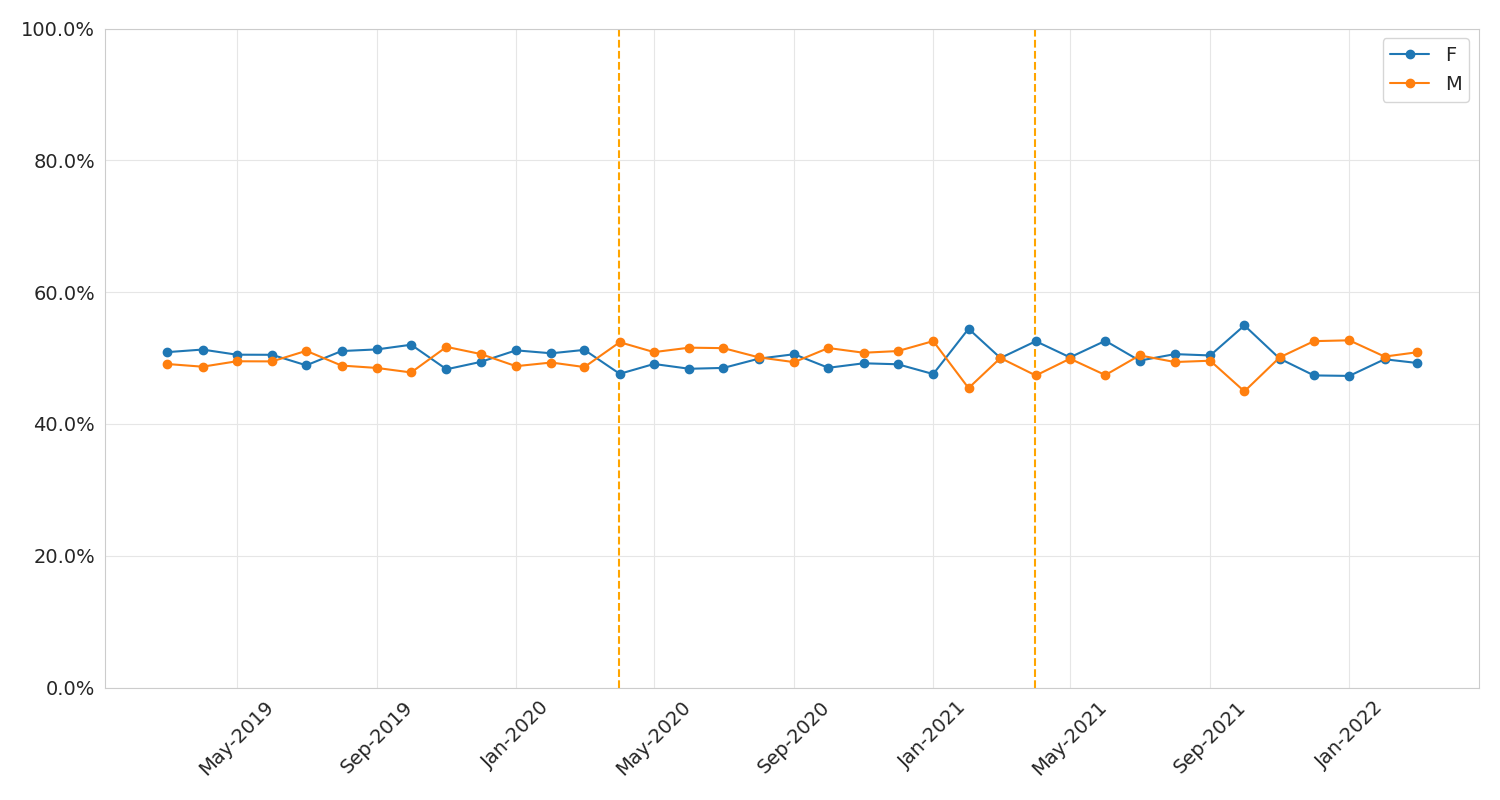

In [15]:
Image(filename=image_paths[demographics[0]])

<a id="results_by_age_band"></a>
### Asthma indicator achievement by age band

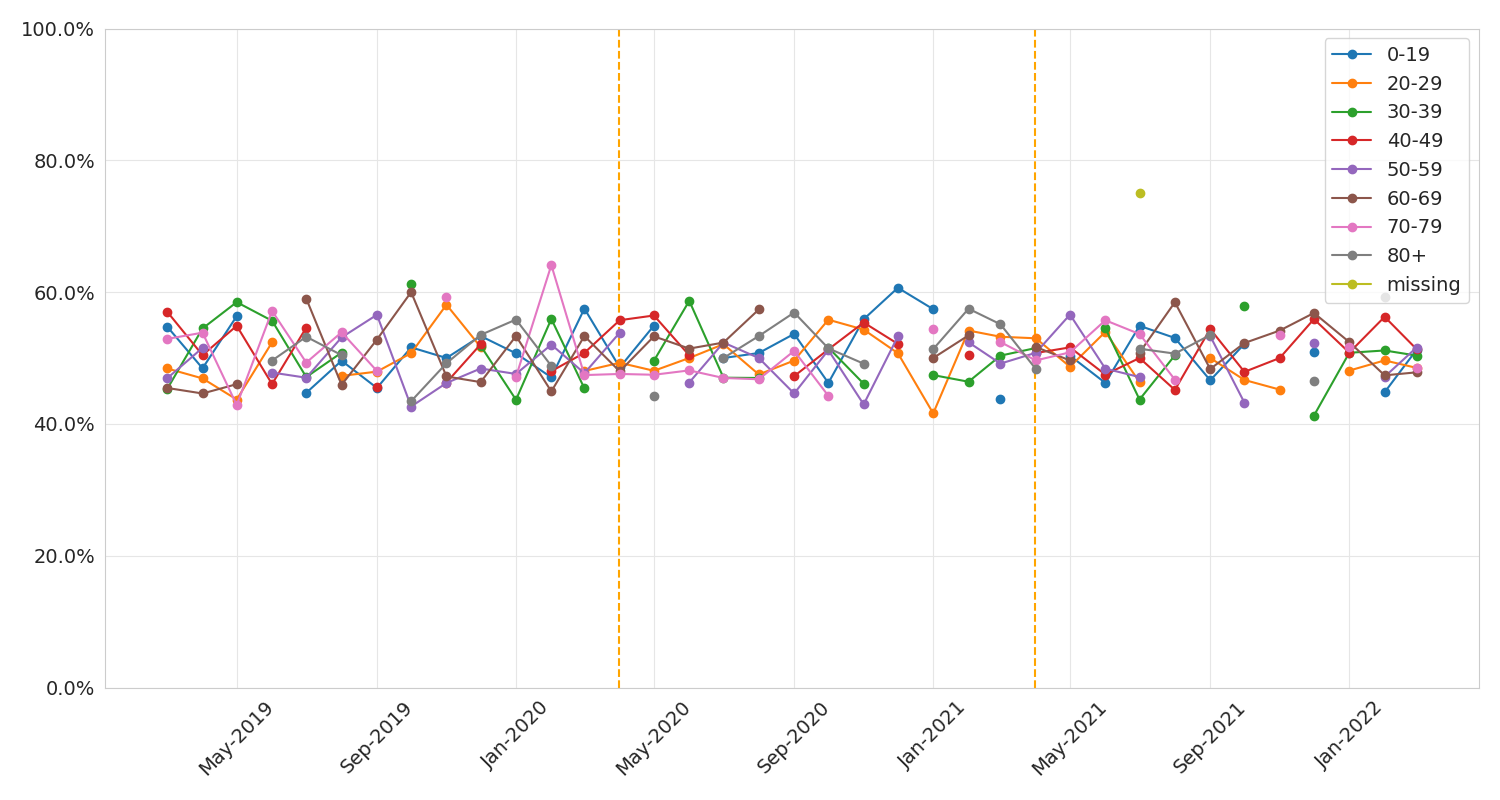

In [16]:
Image(filename=image_paths[demographics[1]])

<a id="results_by_region"></a>

### Asthma indicator achievement by region

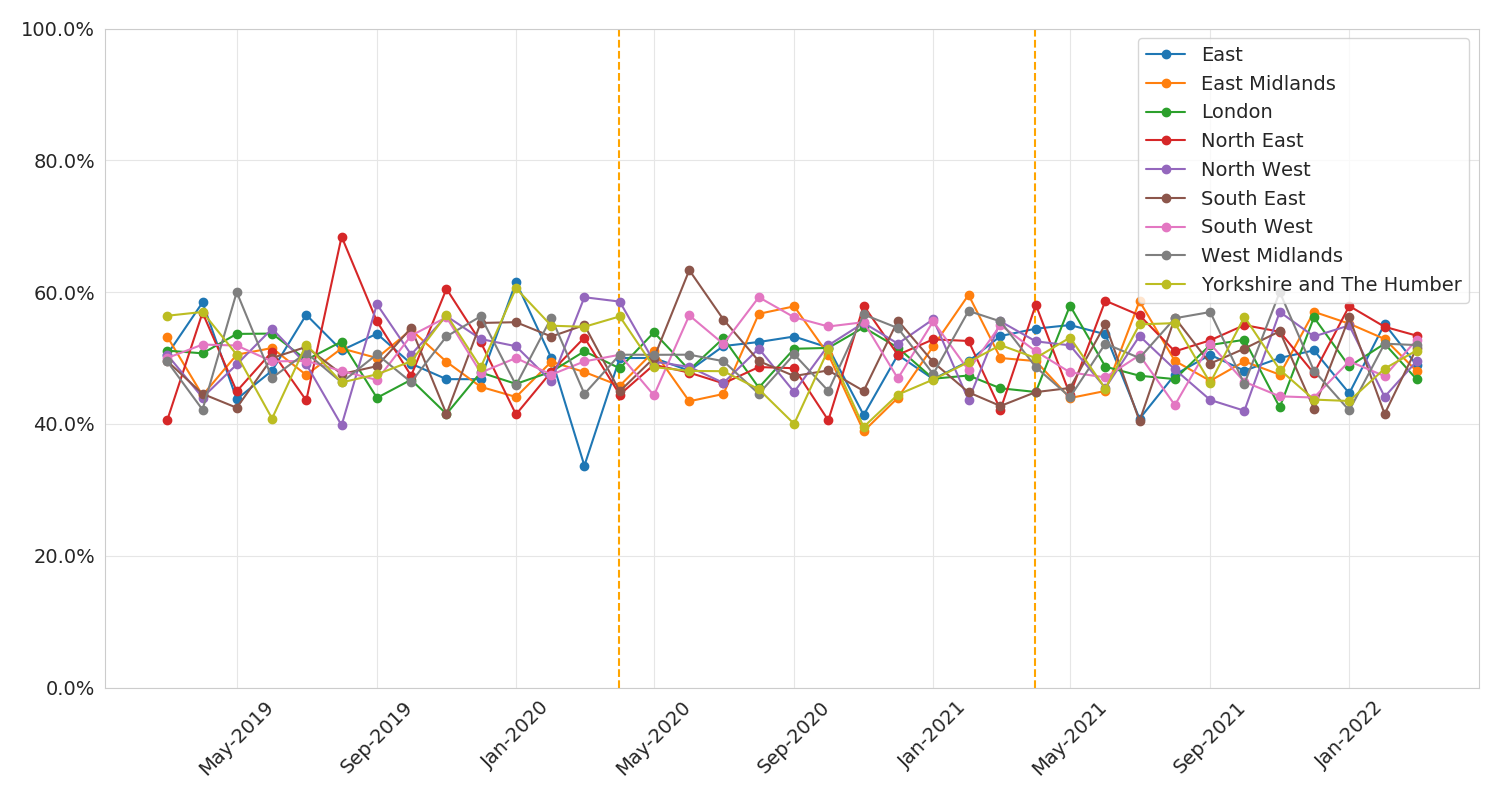

In [17]:
Image(filename=image_paths[demographics[2]])

<a id="results_by_imd"></a>

### Asthma indicator achievement by IMD quintiles

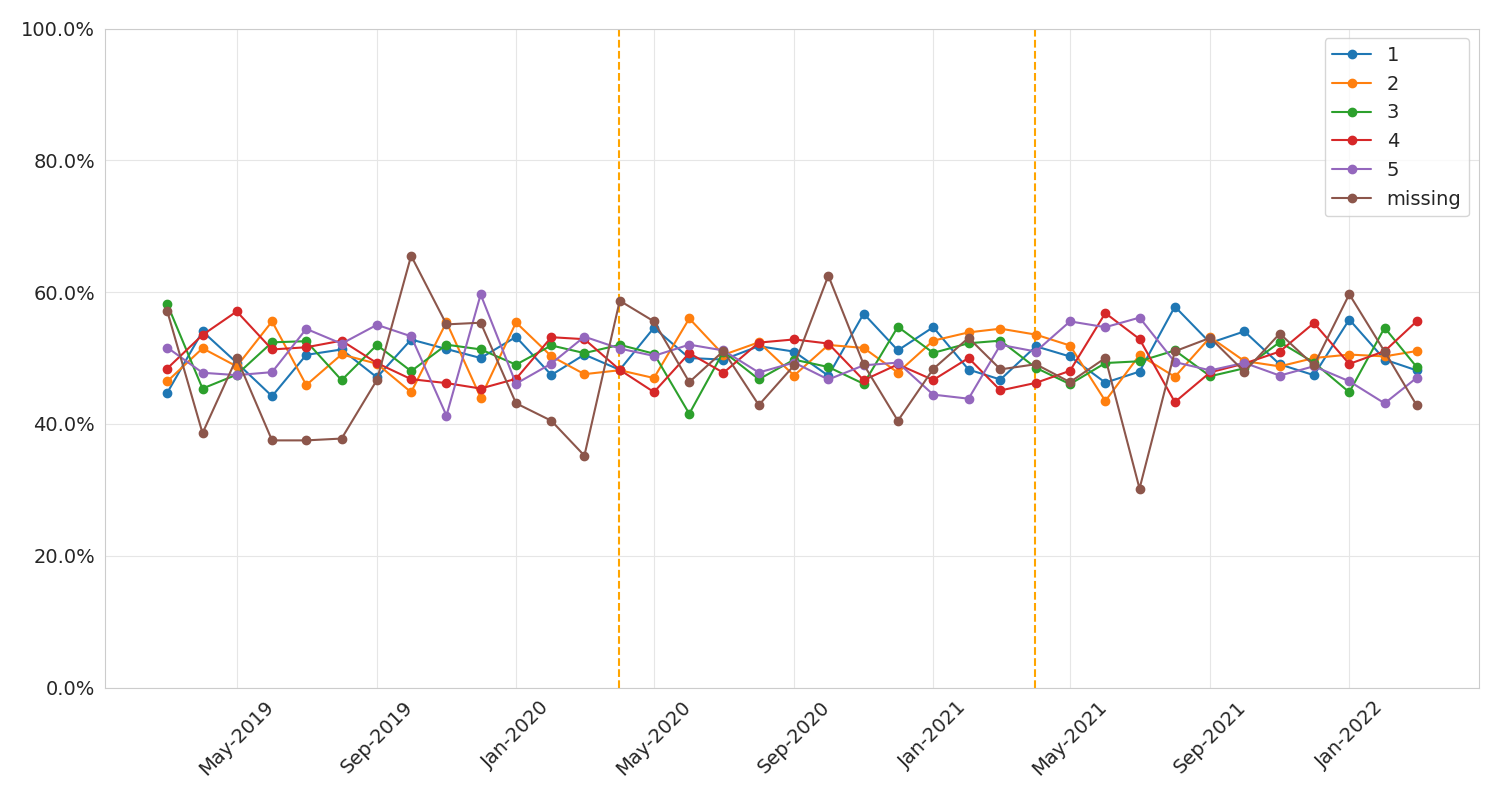

In [18]:
Image(filename=image_paths[demographics[3]])

Please note; values relating to 5 or fewer people have been suppressed and are not present in the graph above. 

<a id="results_by_ethnicity"></a>

### Asthma indicator achievement by ethnicity

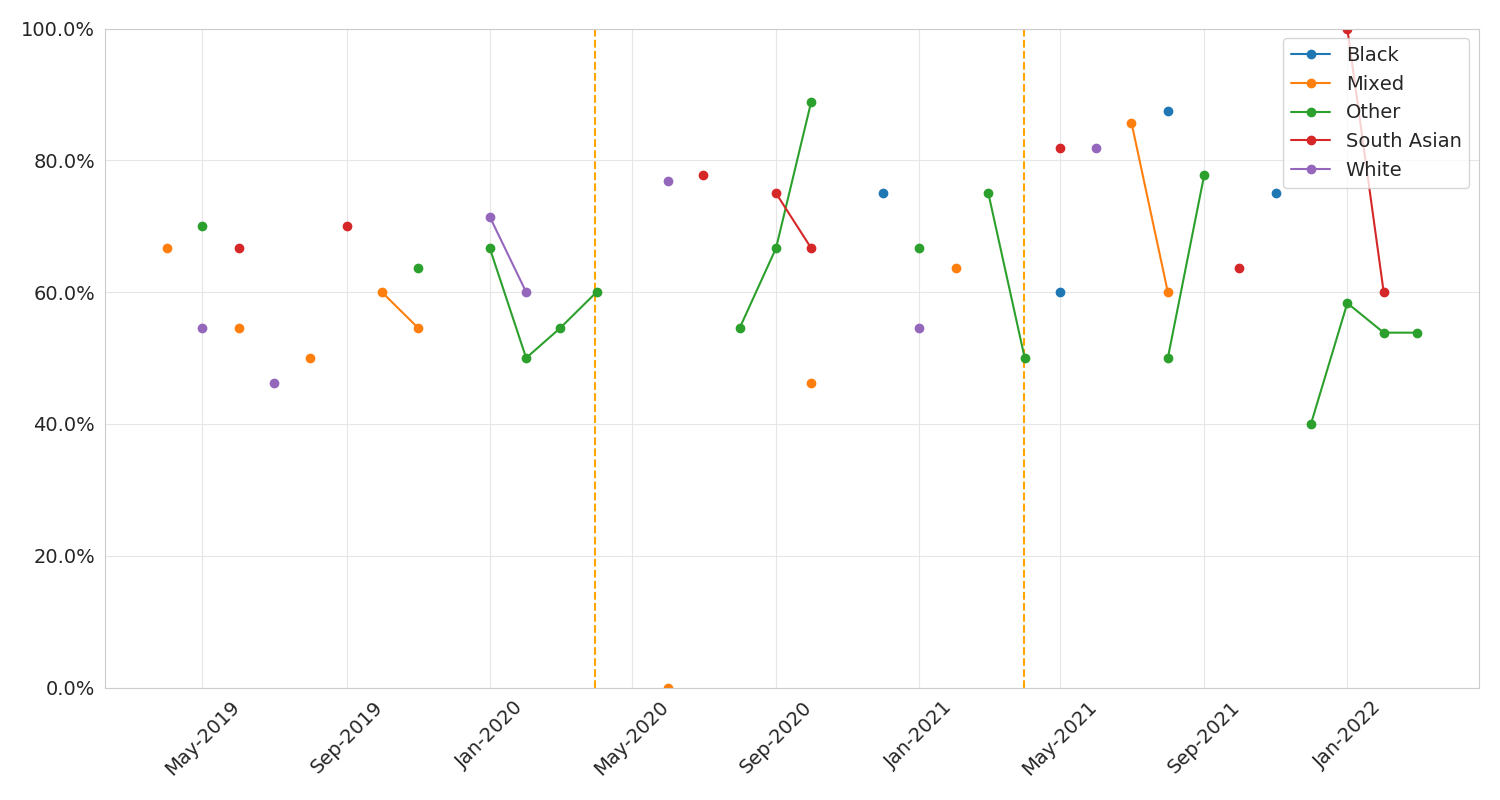

In [19]:
Image(filename=image_paths[demographics[4]])

<a id="results_by_learning_disability"></a>

### Asthma indicator achievement by learning disability


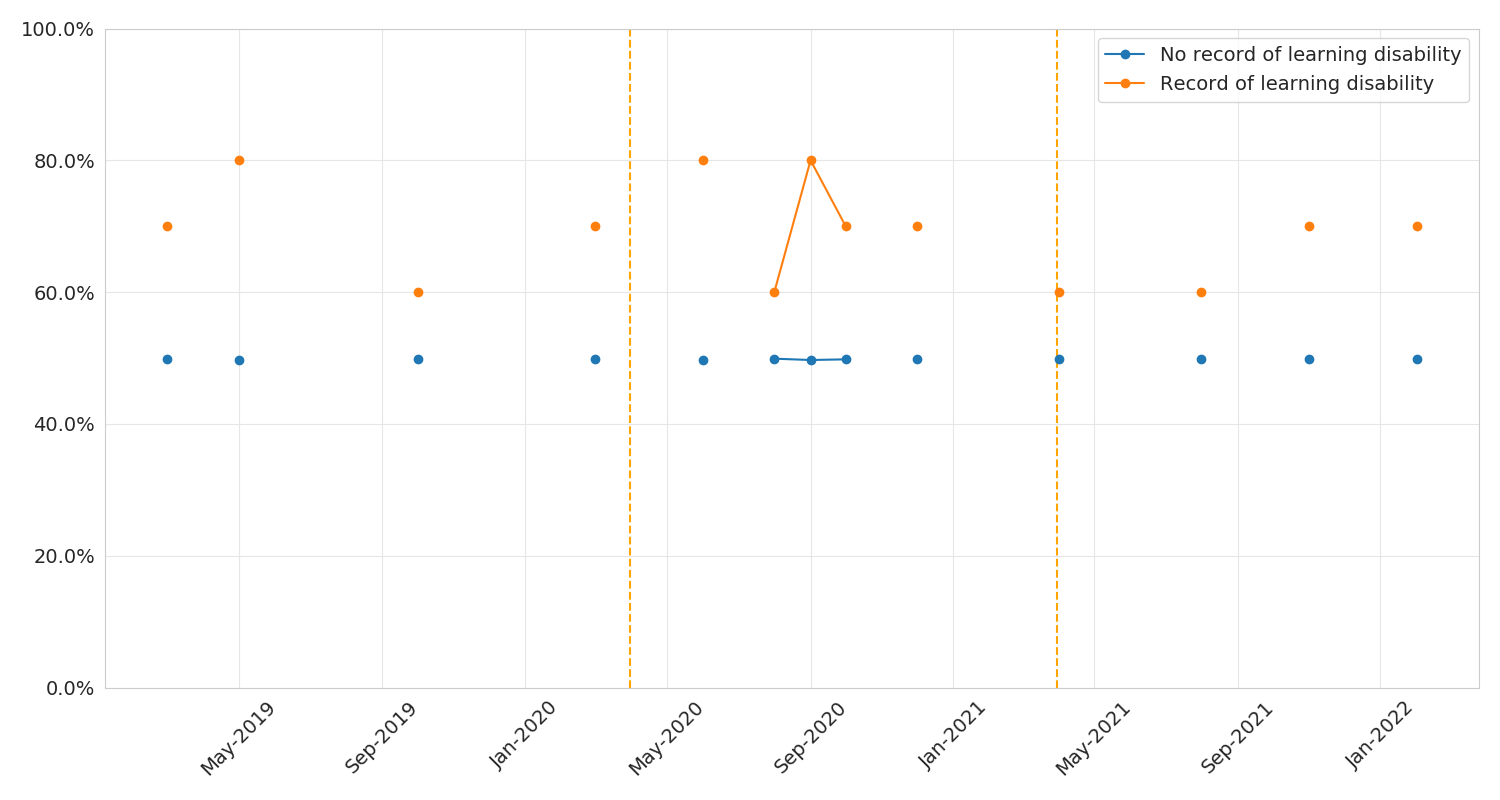

In [20]:
display(Image(filename=image_paths[demographics[5]]))

<a id="results_by_care_home_status"></a>

### Asthma indicator achievement by NHS care home status

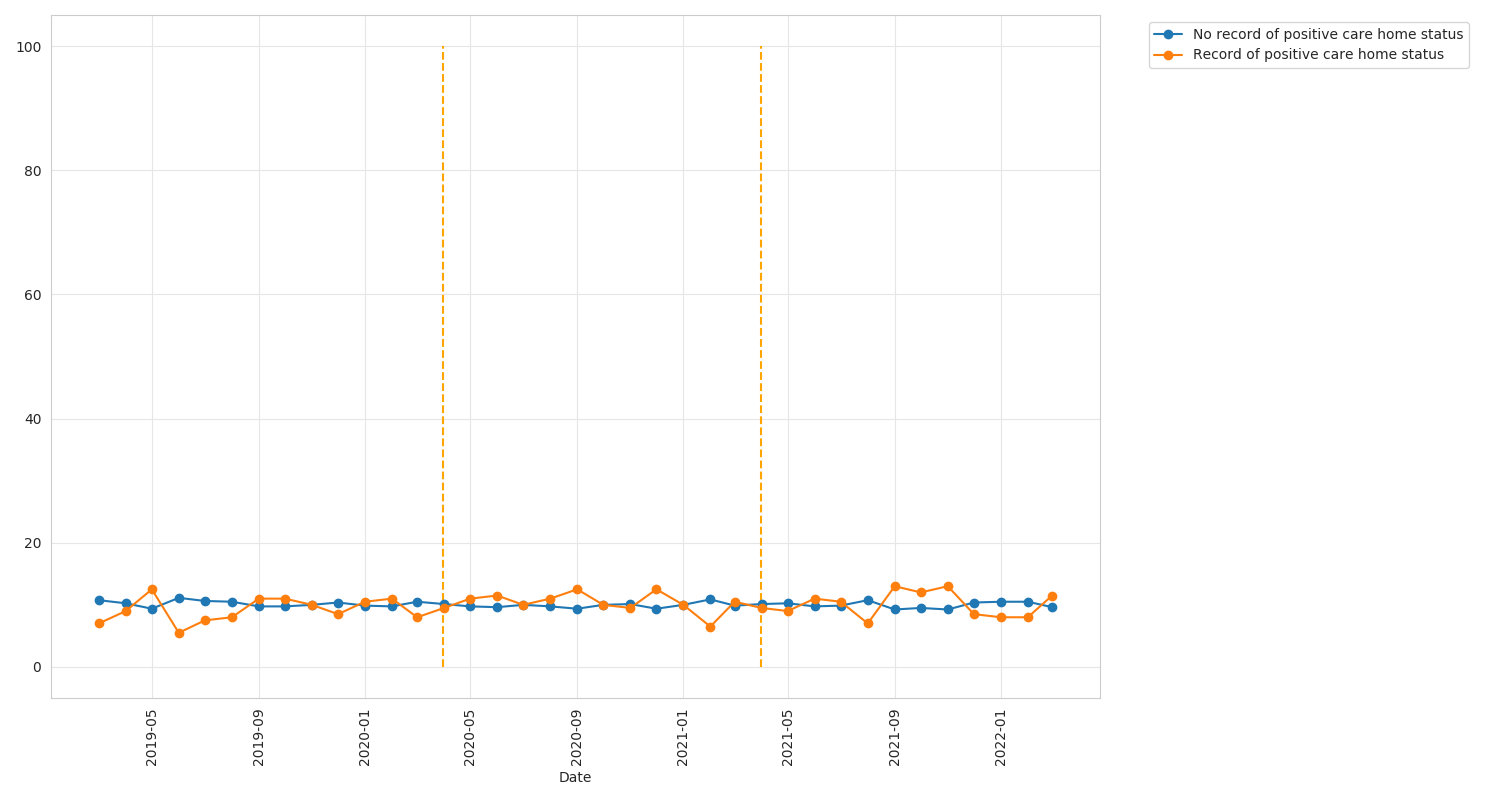

In [12]:
Image(filename=image_paths[demographics[6]]) 

<a id="discussion"></a>
# Discussion

This study has shown that implementing QOF logic for the asthma register in the OpenSAFELY-TPP TRE is possible, and returns asthma prevalence numbers akin with the published figures for previous years. The ability to return monthly prevalence figures allows identification of trends during the COVID-19 pandemic which are not apparent in the annual QOF published prevalence figures. 

There was an increase in the prevalence of asthma in March 2020, compared to all previous pre-pandemic months in the reporting period. This increase in prevalence is not maintained through out the pandemic period to date, with prevalence returning close to pre-pandemic levels 12 months after the initial increase. This may have been due to a larger number of individuals receiving their asthma inhaler prescriptions that month, in response to national lockdowns introduced towards the end of March. This increase in prevalence in March 2020 is present to varying extent across all GP practice prevalence deciles, NHS regions, IMD quintiles and by sex. However this effect is much less pronounced, even non existent, in older age patients, certain ethnicity groups, people with a record of a learning disability and people recorded as living at a care home.  

The prevalence of asthma is different across GP practices, age groups, sex, NHS Regions, ethnicity, and in people with and without a record of a learning disability. Some of these differences may be due to underlying population differences due to age and sex. To unpick this variation, the next stage in our research will be to produce age and sex standardised asthma prevalence rates using the QOF registers logic. 

<a id="references"></a>
# References 

1. Curtis HJ, MacKenna B, Croker R, Inglesby P, Walker AJ, Morley J, et al. OpenSAFELY NHS Service Restoration Observatory 1: describing trends and variation in primary care clinical activity for 23.3 million patients in England during the first wave of COVID-19. Br J Gen Pract [Internet]. 2021 Sep 20 [cited 2021 Oct 5]; Available from: https://bjgp.org/content/early/2021/09/24/BJGP.2021.0380
1. NHS Digital. QOF 2020-21 results. 2021a. https://qof.digital.nhs.uk/
1. NHS Digital. Quality and Outcomes Framework, 2020-21 Official Statistics. 2021b. https://digital.nhs.uk/data-and-information/publications/statistical/quality-and-outcomes-framework-achievement-prevalence-and-exceptions-data/2020-21
1. Williamson EJ, Walker AJ, Bhaskaran K, Bacon S, Bates C, Morton CE, et al. Factors associated with COVID-19-related death using OpenSAFELY. Nature. 2020 Aug;584(7821):430–6. https://www.nature.com/articles/s41586-020-2521-4

